# PROJECT 2

### CS135 Machine Learning
### Student ID: 1409557
### Emmet Hayes

Part 1. In this project, we are trying to develop binary classifiers that generate accurate sentiment labels for single-sentence reviews collected 
from websites like imdb, amazon, and yelp. The input data consists of two columns: the source website of the review, and the review text itself. 
A positive review is given a 1, and a negative review a 0.

The first thing we will need to do is preprocess the data to remove any noisy information from the data that can pollute our model later on. To do this, we will perform 2 steps of preprocessing:
  I. Remove punctuation ('!?.,'), non-english and non-text characters.
  II. Convert all characters to lowercase to unify casing.

For justification of these preprocessing steps, I chose to remove punctuation, non-english and non-text characters from consideration, because they often do not contribute to the sentiment of the sentence, and their presence will only complicate and add more noise the model (even in the case of a ! or ?, it only implies that someone is either passionate or asking a question, but not if what they are passionate or asking about is good or bad). We also don't want to keep track of capital letters, since we should treat the first word of sentence equally compared to any other word in the review. Imagine that one review says 'Incredible!!!' and other says 'It's incredible!!!', both reviews should consider 'incredible' a single word for the purposes of analysis, which helps reduce the dimensionality of our feature space in a minor, but significant way.

Now we need to discuss strategies for generating the final feature-vectors:
I. Vocabulary size of ordering: We select the top N most frequent words from the training set as our vocabulary. The order of the words is determined by their frequency in the training set (from most to least common).
II. Exclusion of rarer words: We will need to define some threshold $M$ such that we exclude any words from our vocabulary that occur in less than $M$% of the total documents.
III. Exclusion of overly common words: We will need to identiy overly common words, also known as 'stopwords' that carry little information about sentiment that should also be excluded from the vocabulary.

For justification of these final feature-vector generation steps, it is clear that we should be ordering our vocabulary based on the frequency of each word. This makes sense intuitively, not only because it makes it easier for our model to find the most frequently-occuring words in the vocabulary, but also because it helps us manage the computational complexity of our model. This is further improved by exluding words that are overly common and do not carry significant sentiment information, as well as excluding words that are too rare to occur often enough to justify adding more dimensionality to our feature space. 

As for explorations that we will be taking in this assignment, I have a few ideas for experiemnts that may lead to more accurate models:

I. Word count or binary representation: We will need to decide whether to count occurences of a word in a document, or a binary representation that simply states where or not a word is present. We will experiment with both approaches to determine which one yields better results.
II. Alternative weighting schemes: We might also experiment with using IDF (inverse document frequency) as an alternative to word counts to give more importance to less frequent but meaningful words.
III. N-grams: We can experiment with using word pairs of n-tuples of words to try and capture more context and improve classification performance.

In [138]:
# All imports and global variables
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

stopwords = [ 'a', 'an', 'the', 'and', 'but', 'or', 'in', 'of', 'on', 'at', 'to', 'from',
              'it', 'is', 'this', 'was', 'for', 'that', 'with', 'my', 'you', 'have', 'are',
               'so', 'as', 'be', 'all', 'one', 'had', 'were', 'we', 'if', 'they', 'has',
              'your', 'by', 'here', 'up', 'also', 'me', 'he', 'when', 'what', 'made',
               'get', 'his', 'her', 'do', 'our', 'use', 'them', 'their', 'way', 'any',
              'there', 've', 'some', 'who', 'its', 'got', 'say', 'am', 'then', 'know' ]

In [57]:
# All helper functions
def preprocess(text):
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = re.sub(r"[^a-zA-z\s]", "", text)
    text = text.lower()
    return text

def do_all_preprocessing(k=500, strategy='bagowords', ngram_range=(1,2)):
    x_train = pd.read_csv('data/data_reviews/x_train.csv', header=None, names=['source', 'review'])
    y_train = pd.read_csv('data/data_reviews/y_train.csv', header=None, names=['is_positive_sentiment'])
    x_train['review'] = x_train['review'].apply(preprocess)
    x_train_raw = x_train
    y_train_raw = y_train
    
    if strategy == 'inversefreq':
        vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=ngram_range)
    else:
        vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=ngram_range)

    chi2_selector = SelectKBest(chi2, k=k)
    scaler = StandardScaler(with_mean=False)
    preprocess_pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('chi2_selector', chi2_selector),
        ('scaler', scaler)
    ])

    x_train = vectorizer.fit_transform(x_train['review'])
    x_train = chi2_selector.fit_transform(x_train, y_train.values.ravel())

    x_train_df = pd.DataFrame(x_train.toarray(), columns=np.array(vectorizer.get_feature_names_out())[chi2_selector.get_support()])

    x_train = scaler.fit_transform(x_train_df)

    x_train_full = x_train
    y_train_full = y_train
    x_train_raw, x_eval_raw, y_train_raw, y_eval_raw = train_test_split(x_train_raw, y_train_raw, test_size=0.2, random_state=41)
    x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=41)
    return x_train, x_eval, y_train, y_eval, x_train_df, preprocess_pipe, x_train_raw, y_train_raw, x_eval_raw, y_eval_raw, x_train_full, y_train_full

def cross_validate_model(model, pipeline, X, y, n_splits=5, random_state=41):
    full_pipeline = Pipeline([
        ('preprocessing', pipeline),
        ('classifier', model)
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Perform cross-validation using the provided number of splits
    cv_scores = cross_val_score(full_pipeline, X, y.values.ravel(), cv=cv, scoring='accuracy')

    # Print the cross-validation results
    print(f'{n_splits}-Fold Cross-Validation:')
    print(f'- Average accuracy: {np.mean(cv_scores):.4f}')
    print(f'- Standard deviation: {np.std(cv_scores):.4f}')

def plot_top_words(x_train_df):
    top_n = 50
    sum_words = x_train_df.sum(axis=0)
    top_words = sum_words.sort_values(ascending=False).head(top_n)

    # Create a new DataFrame with only the top 50 most frequent words
    x_train_top_words = x_train_df[top_words.index]

    # Create a heatmap of the top 50 most frequent words
    plt.figure(figsize=(20, 20))
    sns.heatmap(x_train_top_words.iloc[:2400, :].T)  # Display only the first 100 samples
    plt.title("Top 50 Most Frequent Words (First 300 Samples)")
    plt.xlabel("Samples")
    plt.ylabel("Words")

    # Set up the x ticks
    num_ticks = 20
    tick_step = len(x_train_top_words.iloc[:2400, :]) // num_ticks
    tick_locations = list(range(0, len(x_train_top_words.iloc[:2400, :]), tick_step))
    tick_labels = tick_locations

    plt.xticks(tick_locations, tick_labels)
    plt.show()

def plot_confusion_matrix(y_eval, y_pred, model_name):
    acc = accuracy_score(y_eval, y_pred)
    print(f"Accuracy: {acc}")
    print("Classification report:")
    print(classification_report(y_eval, y_pred))
    sns.heatmap(confusion_matrix(y_eval, y_pred), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(str(model_name) + ' Confusion Matrix')
    plt.show()

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training steps")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()

def plot_mlp_loss_curve_after_fit(mlp_model, title="MLP Loss Curve"):
    if hasattr(mlp_model, 'loss_curve_'):
        epochs = list(range(1, len(mlp_model.loss_curve_) + 1))
    else:
        return
    plt.figure()
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.plot(epochs, mlp_model.loss_curve_, 'o-', color="r", label="Loss")
    plt.legend(loc="best")
    plt.show()

def plot_svm_decision_boundary_3D(clf, X, y, feature_names, step_size=1.0):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    y = y.ravel()

    unique_labels = np.unique(y)
    colors = ['r', 'b']
    for idx, label in enumerate(unique_labels):
        in_class = (y == label)
        ax.scatter(X[in_class, 0], X[in_class, 1], X[in_class, 2], c=colors[idx], edgecolors='k', marker='o', s=50, alpha=0.6)

    # Create a mesh grid for the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, step_size),
                             np.arange(y_min, y_max, step_size),
                             np.arange(z_min, z_max, step_size))

    # Predict the class for each point in the mesh grid
    X_grid = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
    decision_values = clf.decision_function(X_grid)
    predictions = clf.predict(X_grid)

    # Reshape the decision values and predictions back into the meshgrid shape
    decision_values = decision_values.reshape(xx.shape)
    predictions = predictions.reshape(xx.shape)
    
   # Reshape xx, yy, and zz into 2D arrays
    xx = xx.reshape(-1, 1)
    yy = yy.reshape(-1, 1)
    zz = zz.reshape(-1, 1)

    for i in range(2):
        print("shape of xx: " + str(xx.shape))
        print("shape of yy: " + str(yy.shape))
        print("shape of zz:" + str(zz.shape))
        print("predictions shape:" + str((predictions == i).shape))
        preds = (predictions == i).reshape(-1, 1)
        ax.plot_surface(xx, yy, zz * preds, color='gray', alpha=0.3)

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title('SVM Decision Plane in 3D')

    plt.show()

def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def plot_results_table(results_df, num_rows=None):
    if num_rows is not None:
        results_df = results_df.head(num_rows)

    # Styling the DataFrame
    def wrap_text(text, max_width=50):
        return '<br>'.join(textwrap.wrap(text, max_width))
    
    wrapped_review = results_df['review'].apply(wrap_text)
    
    styles = [
        dict(selector="th", props=[("text-align", "left"), ("font-size", "12pt")]),
        dict(selector="td", props=[("text-align", "left"), ("font-size", "12pt")]),
        dict(selector="tr:hover td:hover", props=[("background-color", "#f1c40f")])
    ]
    
    styled_df = (
        results_df.style
        .set_table_styles(styles)
        .hide_index()
        .format({'review': lambda x: wrapped_review[results_df[results_df['review'] == x].index[0]]})
    )

    # Display the styled DataFrame
    display(styled_df)

Part 2: Creating the logistic regression model

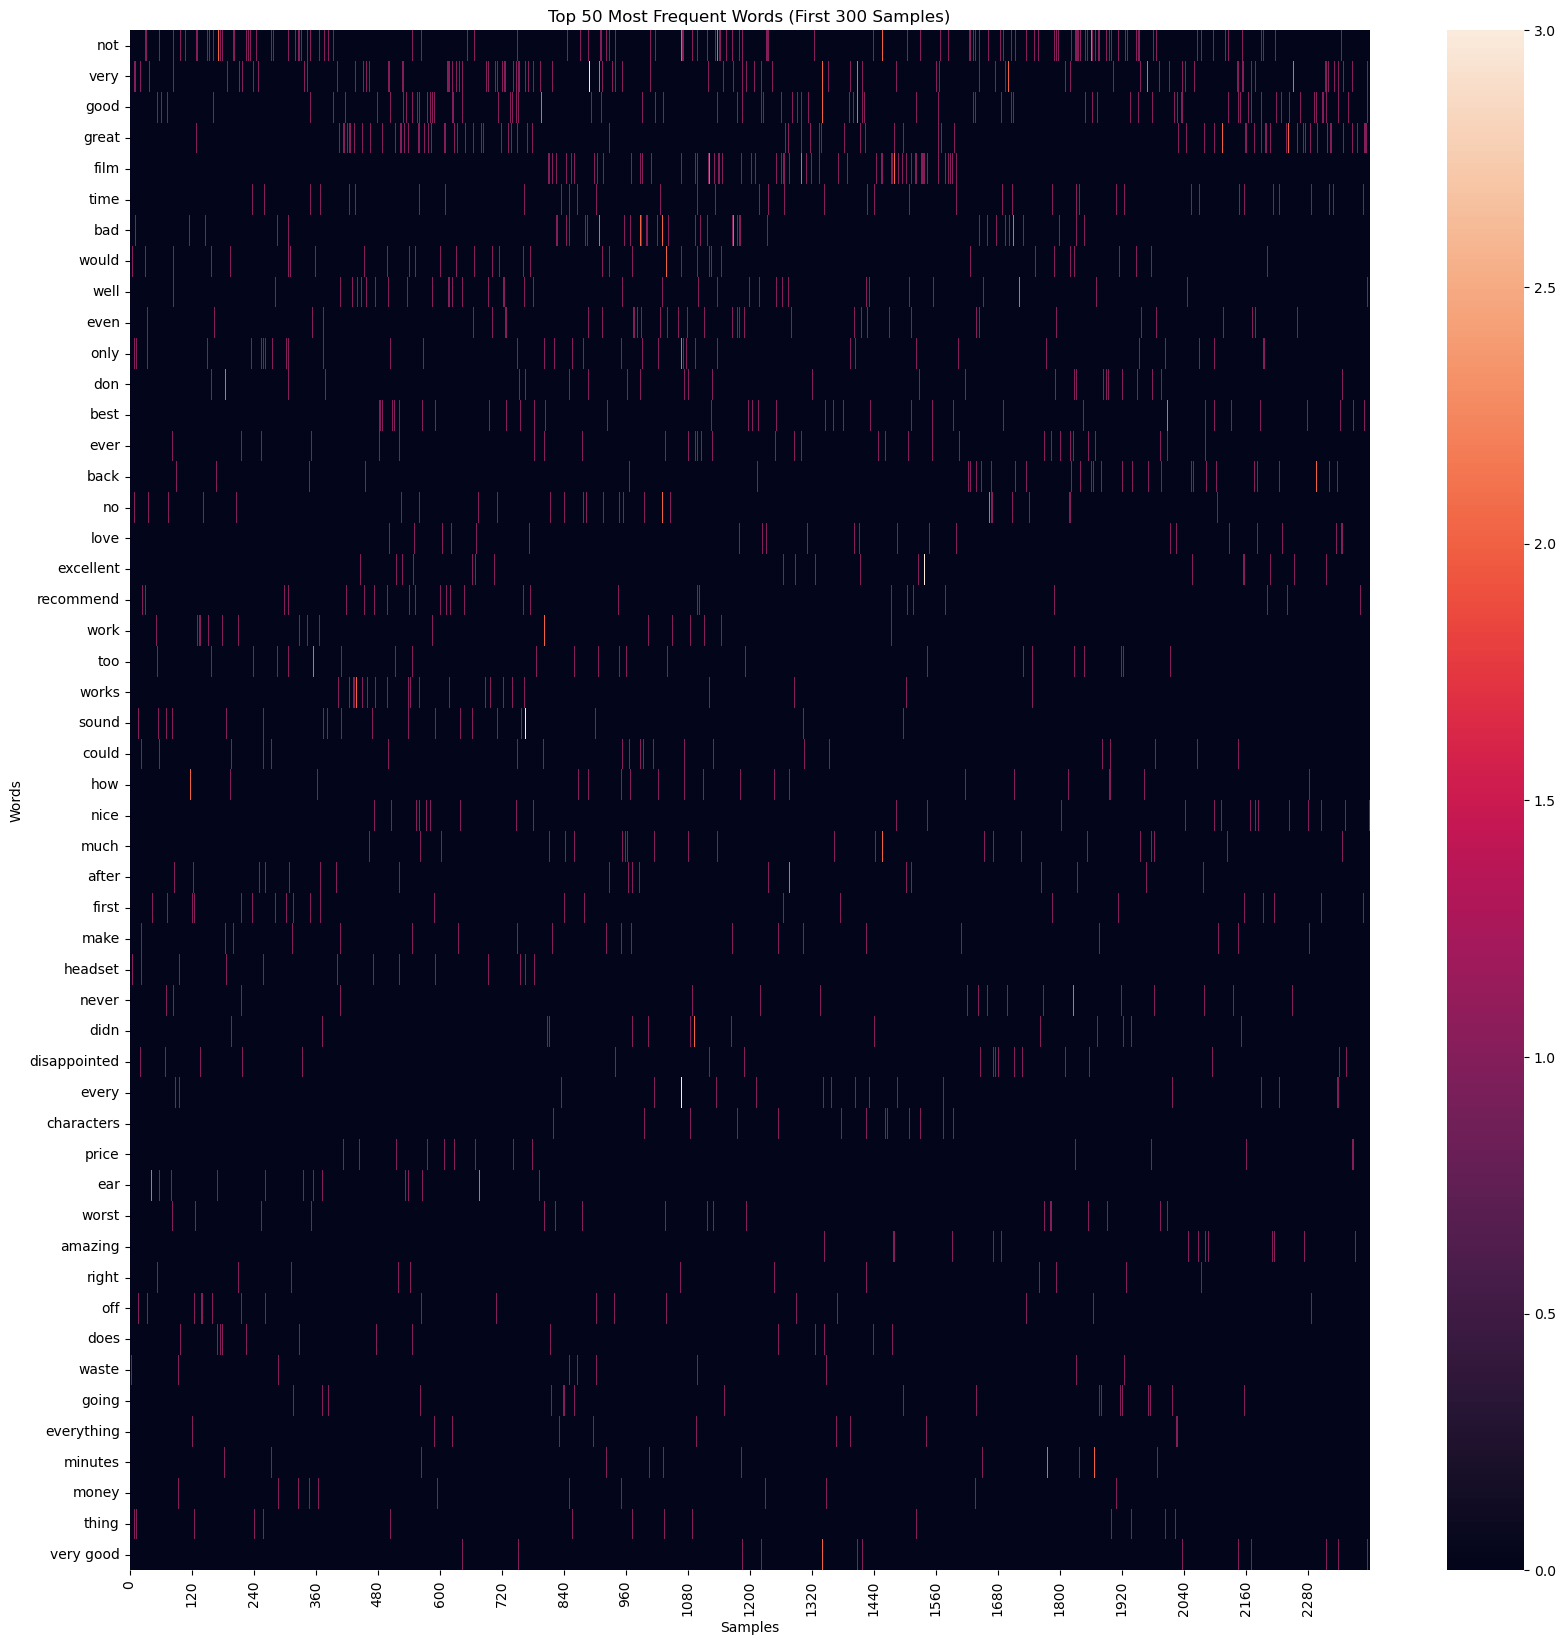

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


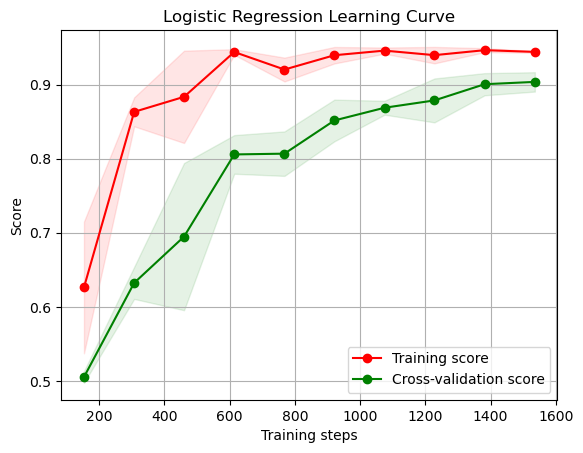

Accuracy: 0.9147609147609148
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       238
           1       0.90      0.93      0.92       243

    accuracy                           0.91       481
   macro avg       0.92      0.91      0.91       481
weighted avg       0.92      0.91      0.91       481



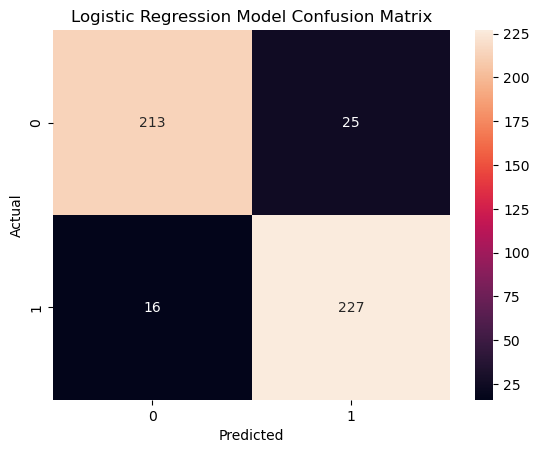

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


5-Fold Cross-Validation:
- Average accuracy: 0.8005
- Standard deviation: 0.0131


In [3]:
x_train, x_eval, y_train, y_eval, x_train_df, preprocess_pipe, x_train_raw_lr, y_train_raw_lr, x_eval_raw_lr, y_eval_raw_lr, _, _ = do_all_preprocessing(1450, (1,2))
plot_top_words(x_train_df)

logreg_best = LogisticRegression(solver='lbfgs',
                                 C=0.0001, 
                                 penalty='l2', 
                                 max_iter=100)
logreg_best.fit(x_train, y_train.values.ravel())

y_pred = logreg_best.predict(x_eval)

plot_learning_curve(logreg_best, x_train, y_train.values.ravel(), 
                    title="Logistic Regression Learning Curve")
plot_confusion_matrix(y_eval, y_pred, model_name='Logistic Regression Model')

x_total_raw = pd.concat([x_eval_raw_lr, x_train_raw_lr])
y_total_raw = pd.concat([y_eval_raw_lr, y_train_raw_lr])
cross_validate_model(logreg_best, preprocess_pipe, x_total_raw['review'], y_total_raw, 5)

Part 3: Creating the Multilayer Perceptron model

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


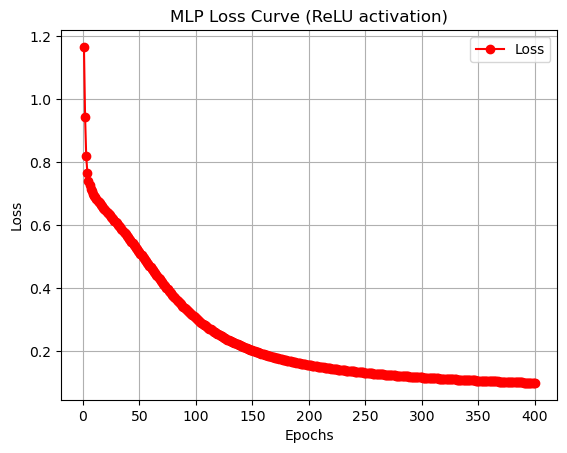

Accuracy: 0.9064449064449065
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       238
           1       0.88      0.95      0.91       243

    accuracy                           0.91       481
   macro avg       0.91      0.91      0.91       481
weighted avg       0.91      0.91      0.91       481



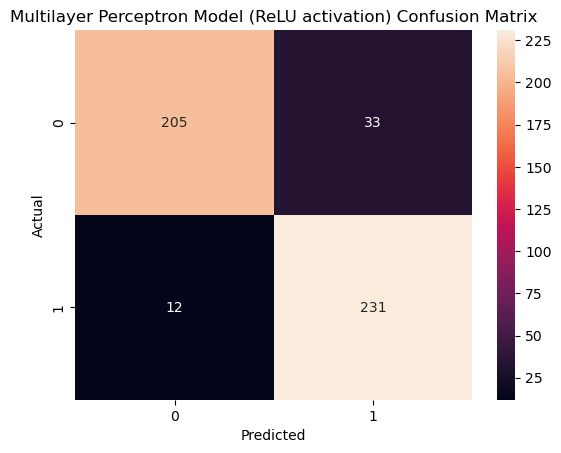

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\

5-Fold Cross-Validation:
- Average accuracy: 0.8026
- Standard deviation: 0.0132


c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:

x_train, x_eval, y_train, y_eval, x_train_df, preprocess_pipe, x_train_raw_nn, y_train_raw_nn, x_eval_raw_nn, y_eval_raw_nn, _, _ = do_all_preprocessing(1450)

mlp_best = MLPClassifier(solver='sgd',
                         hidden_layer_sizes=(88, ),
                         activation='logistic',
                         random_state=5, 
                         max_iter=400)
mlp_best.fit(x_train, y_train.values.ravel())

y_pred = mlp_best.predict(x_eval)
plot_mlp_loss_curve_after_fit(mlp_best, title="MLP Loss Curve (ReLU activation)")
plot_confusion_matrix(y_eval, y_pred, model_name='Multilayer Perceptron Model (ReLU activation)')

x_total_raw = pd.concat([x_eval_raw_nn, x_train_raw_nn])
y_total_raw = pd.concat([y_eval_raw_nn, y_train_raw_nn])
cross_validate_model(mlp_best, preprocess_pipe, x_total_raw['review'], y_total_raw, 5)


c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\gelli\AppData\Local\Temp\ipykernel_13156\1961207803.py:204: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  results_df.style


source,review,truth,prediction
imdb,but i thought his acting was skilled,1,1
amazon,so i basically threw my money out the window fornothing,0,0
imdb,definitely worth seeing it s the sort of thoughtprovoking film that forces you to question yourown threshold of loneliness,1,0
yelp,your servers suck wait correction our serverheimer sucked,0,0
yelp,the meat was pretty dry i had the sliced brisketand pulled pork,0,0
yelp,dessert panna cotta was amazing,1,1
yelp,i didn t know pulled pork could be soooo delicious,1,1
yelp,at least min passed in between us ordering and thefood arriving and it wasn t that busy,0,0
yelp,terrible management,0,0
yelp,my ribeye steak was cooked perfectly and had greatmesquite flavor,1,1


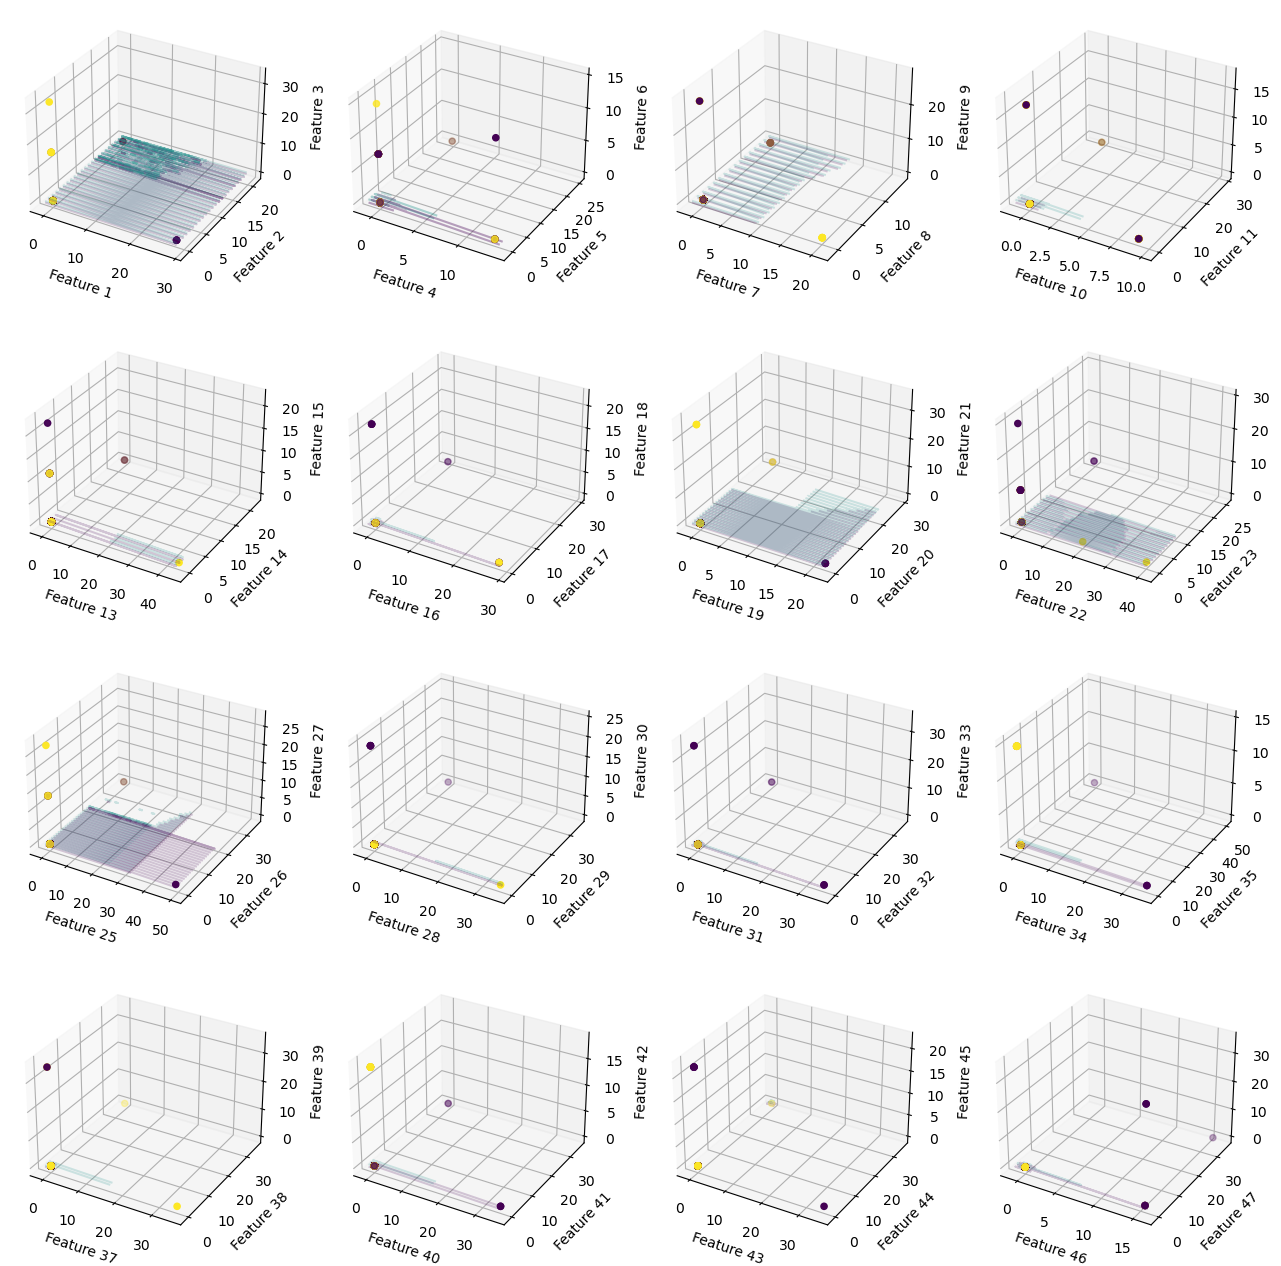

Accuracy: 0.896049896049896
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       238
           1       0.88      0.91      0.90       243

    accuracy                           0.90       481
   macro avg       0.90      0.90      0.90       481
weighted avg       0.90      0.90      0.90       481



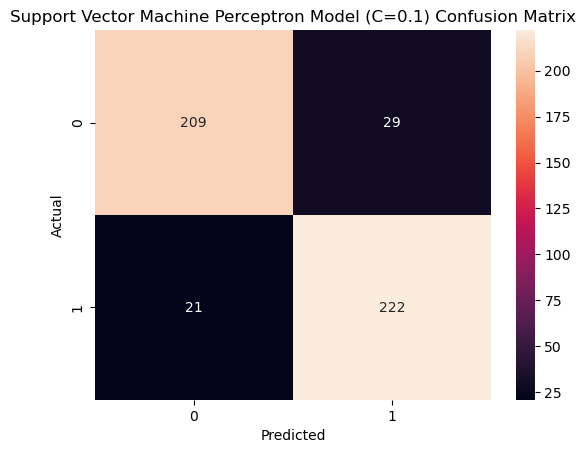

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


5-Fold Cross-Validation:
- Average accuracy: 0.8038
- Standard deviation: 0.0092


In [17]:
x_train, x_eval, y_train, y_eval, x_train_df, preprocess_pipe, x_train_raw_svm, y_train_raw_svm, x_eval_raw_svm, y_eval_raw_svm, _, _ = do_all_preprocessing(1450)
svm_best = SVC(C=1, kernel='rbf', gamma='scale', random_state=4, probability=True)
svm_best.fit(x_train, y_train.values.ravel())
y_pred = svm_best.predict(x_eval)
y_train = y_train.values

mask = np.array([is_float(y) for y in y_train])

y_train = y_train[mask]
x_train = x_train.astype('float')
y_train = y_train.astype('float')

x_total_raw = pd.concat([x_eval_raw_svm, x_train_raw_svm])
y_total_raw = pd.concat([y_eval_raw_svm, y_train_raw_svm])

# Convert the preprocessed reviews to a dense array before prediction
dense_reviews = preprocess_pipe.transform(x_total_raw['review']).toarray()

results_df = x_total_raw[['source', 'review']].copy()
results_df['truth'] = y_total_raw
results_df['prediction'] = svm_best.predict(dense_reviews)

plot_results_table(results_df, num_rows=50)

# Choose the features and fit the model
fig = plt.figure(figsize=(16, 16))

for i in range(16):
    x_selected = x_train[:, i*3:i*3 + 3]
    plot_clf_3D = SVC(C=1, kernel='rbf', gamma='scale', random_state=4)
    plot_clf_3D.fit(x_selected[1:], y_train.ravel())
    ax = fig.add_subplot(4, 4, i+1, projection='3d')

    step_size = 1.0
    x_min, x_max = x_selected[:, 0].min() - 1, x_selected[:, 0].max() + 1
    y_min, y_max = x_selected[:, 1].min() - 1, x_selected[:, 1].max() + 1
    z_min, z_max = x_selected[:, 2].min() - 1, x_selected[:, 2].max() + 1
    xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, step_size),
                             np.arange(y_min, y_max, step_size),
                             np.arange(z_min, z_max, step_size))

    X_plot = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
    Z = plot_clf_3D.predict(X_plot)
    Z = Z.reshape(xx.shape)
    Z = Z.reshape((Z.shape[0]*Z.shape[1], Z.shape[2])).T
    xx = xx.reshape((xx.shape[0]*xx.shape[1], xx.shape[2])).T
    yy = yy.reshape((yy.shape[0]*yy.shape[1], yy.shape[2])).T

    ax.scatter(x_selected[1:, 0], x_selected[1:, 1], x_selected[1:, 2], c=y_train, cmap='viridis')
    ax.contour3D(xx, yy, Z, 1, alpha=0.2)
    ax.set_xlabel('Feature {}'.format(i*3 + 1))
    ax.set_ylabel('Feature {}'.format(i*3 + 2))
    ax.set_zlabel('Feature {}'.format(i*3 + 3))

plt.show()

plot_confusion_matrix(y_eval, y_pred, model_name='Support Vector Machine Perceptron Model (C=0.1)')
cross_validate_model(svm_best, preprocess_pipe, x_total_raw['review'], y_total_raw)


Optimal threshold: 1.0
Accuracy: 0.5322245322245323
Classification report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       238
           1       1.00      0.07      0.14       243

    accuracy                           0.53       481
   macro avg       0.76      0.54      0.41       481
weighted avg       0.76      0.53      0.41       481



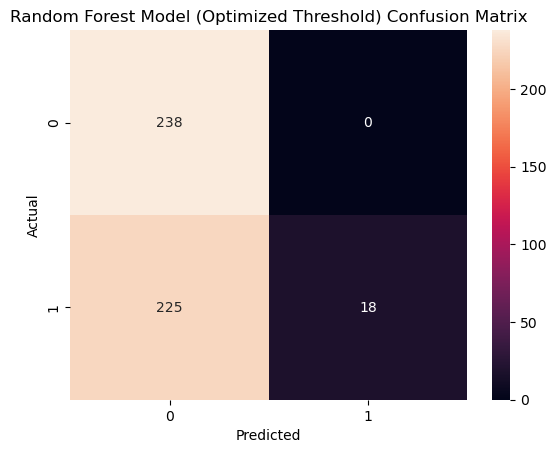

Accuracy: 0.8544698544698545
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       238
           1       0.88      0.82      0.85       243

    accuracy                           0.85       481
   macro avg       0.86      0.85      0.85       481
weighted avg       0.86      0.85      0.85       481



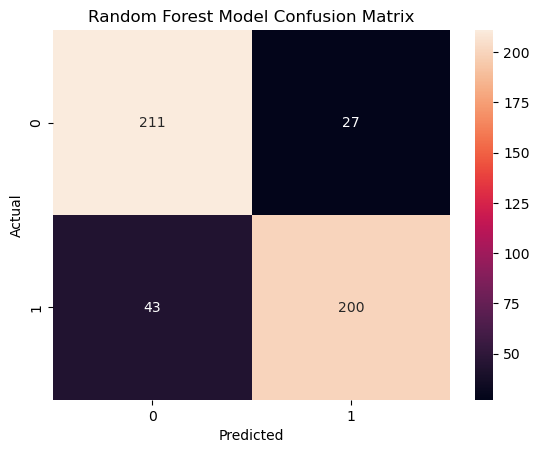

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


5-Fold Cross-Validation:
- Average accuracy: 0.8159
- Standard deviation: 0.0098


In [145]:
# Reusing the preprocessed data from previous steps
x_train, x_eval, y_train, y_eval, x_train_df, preprocess_pipe, x_train_raw_nn, y_train_raw_nn, x_eval_raw_nn, y_eval_raw_nn, _, _ = do_all_preprocessing(1450)

# Create a RandomForestClassifier model
rf_best = RandomForestClassifier(n_estimators=500,  # Number of trees in the forest
                                 max_depth=None,    # Maximum depth of the trees
                                 random_state=5,
                                 min_samples_split=5,
                                 max_features='log2',
                                 class_weight='balanced')    # Random seed

# Train the RandomForestClassifier model
rf_best.fit(x_train, y_train.values.ravel())

# Predict probabilities for the evaluation set
y_pred_proba_rf = rf_best.predict_proba(x_eval)[:, 1]

# Convert y_eval to integers
y_eval_int = y_eval.astype(int)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_eval_int, y_pred_proba_rf)

# Calculate the optimal threshold based on the desired precision-recall trade-off
optimal_idx = np.argmax(precision[:-1] - recall[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# Apply the optimal threshold to the predicted probabilities to get the final predictions
y_pred_rf_optimized = (y_pred_proba_rf >= optimal_threshold).astype(int)

# Plot confusion matrix with the optimized threshold
plot_confusion_matrix(y_eval_int, y_pred_rf_optimized, model_name='Random Forest Model (Optimized Threshold)')
# Predict the evaluation set
y_pred_rf = rf_best.predict(x_eval)

# Plot confusion matrix
plot_confusion_matrix(y_eval, y_pred_rf, model_name='Random Forest Model')

# Cross-validate the model
x_total_raw = pd.concat([x_eval_raw_nn, x_train_raw_nn])
y_total_raw = pd.concat([y_eval_raw_nn, y_train_raw_nn])
cross_validate_model(rf_best, preprocess_pipe, x_total_raw['review'], y_total_raw, 5)

In [132]:
_, _, _, _, _, _, _, _, _, _, x_train_full, y_train_full = do_all_preprocessing(1450)

print("refitting all models")
svm_best.fit(x_train_full[1:], y_train_full.values.ravel()[1:])
mlp_best.fit(x_train_full[1:], y_train_full.values.ravel()[1:])
logreg_best.fit(x_train_full[1:], y_train_full.values.ravel()[1:])
rf_best.fit(x_train_full[1:], y_train_full.values.ravel()[1:])
print("refitting step done")

refitting all models


c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


refitting step done


In [133]:

# Generate predictions for each base model using cross-validation
svm_val_preds = cross_val_predict(svm_best, x_train_full[1:], y_train_full.values.ravel()[1:], method='predict_proba')[:, 1].reshape(-1, 1)
mlp_val_preds = cross_val_predict(mlp_best, x_train_full[1:], y_train_full.values.ravel()[1:], method='predict_proba')[:, 1].reshape(-1, 1)
logreg_val_preds = cross_val_predict(logreg_best, x_train_full[1:], y_train_full.values.ravel()[1:], method='predict_proba')[:, 1].reshape(-1, 1)
rf_val_preds = cross_val_predict(rf_best, x_train_full[1:], y_train_full.values.ravel()[1:], method='predict_proba')[:, 1].reshape(-1, 1)

c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  war

In [135]:
# Stack the predictions horizontally (i.e., concatenate them as new columns)
meta_features_val = np.hstack((mlp_val_preds, rf_val_preds, svm_val_preds))
print(str(meta_features_val.shape))
meta_model = LogisticRegression()
print(str(meta_features_val.shape))
# Train the meta-model on the stacked predictions
meta_model.fit(meta_features_val, y_train_full.values.ravel()[1:])


(2400, 3)
(2400, 3)


LogisticRegression()

In [139]:
x_test = pd.read_csv('data/data_reviews/x_test.csv', header=None, names=['source', 'review'], skiprows=1)
x_test['review'] = x_test['review'].apply(preprocess)

x_test_preprocessed = preprocess_pipe.transform(x_test['review'])

y_pred_lr = logreg_best.predict_proba(x_test_preprocessed)[:, 1]
y_pred_nn = mlp_best.predict_proba(x_test_preprocessed)[:, 1]
y_pred_svm = svm_best.predict(x_test_preprocessed.toarray())
y_pred_rf = rf_best.predict_proba(x_test_preprocessed.toarray())[:, 1]
y_pred_rf = (y_pred_proba_rf >= optimal_threshold).astype(int)
meta_features_test = np.column_stack((y_pred_nn, y_pred_rf, y_pred_svm, y_pred_lr))

y_pred_em = meta_model.predict(meta_features_test)

y_pred_lr = (y_pred_lr >= 0.5).astype(int)
np.savetxt('yproba1_test_lr.txt', y_pred_lr, fmt='%d')

y_pred_nn = (y_pred_nn >= 0.5).astype(int)
np.savetxt('yproba1_test_nn.txt', y_pred_nn, fmt='%d')


np.savetxt('yproba1_test_svm.txt', y_pred_svm.astype(int), fmt='%d')
np.savetxt('yproba1_test_rf.txt', y_pred_rf.astype(int), fmt='%d')
np.savetxt('yproba1_test.txt', y_pred_em.astype(int), fmt='%d')



c:\Users\gelli\miniconda3\envs\ml135_env_sp21\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 4 features, but LogisticRegression is expecting 3 features as input.